<div align="center">
  <img src="Images/image2.jpg" alt="Logo" width="500">
  <h1 style="font-size: 40px; text-decoration: underline;">TRASH IMAGE CLASSIFICATION</h1>
</div>


***
## BUSINESS UNDERSTANDING
***
### Overview/Background Information

Konza City Technopolis is a burgeoning smart city in Kenya, designed to be a hub of technology, innovation, and sustainability. As part of its commitment to environmental sustainability, Konza City aims to implement advanced waste management solutions. iDump, a waste management company, has been contracted to develop and deploy an efficient waste segregation system that separates waste into different categories for recycling. This initiative will play a crucial role in maintaining the city’s cleanliness, reducing environmental impact, and promoting recycling practices.

Solid waste encompasses all materials that result from human and societal activities but have lost their utility or desirability. This waste may be items belonging to three primary groups:
- **Recyclable Inorganics:** Fit for repurposing, e.g., plastics, metals.
- **Divertible Organics:** From which energy and fertilizer can be derived, e.g., food and vegetation.
- **Inorganic Materials Requiring Landfill:** E.g., ceramics, treated wood.

Improper management of waste disposal poses significant risks to environmental sustainability and human health, resulting from toxic wastewater byproducts and the global warming potential of methane in landfill gas. In 2020, 3.48% of global greenhouse gas production was attributed to the waste disposal sector, with methane from landfill gases accounting for 20% of worldwide methane emissions the following year. The chemical composition and production of both wastewater and landfill gases heavily depend on the organic content within the waste processed, with significant variations arising in the presence of food and vegetation materials.

Detection of the waste types under meticulously refined material classes in both an accurate and timely manner is essential for sustainable waste management, ensuring accountability for both seasonal variations and recycling uptake.

### Problem Statement

![Problematic Garbage Disposal](Images\landfill.jpeg)

Konza City Technopolis faces significant challenges in managing the diverse and large volume of waste generated by its residents and businesses, projected to peak at 240,000 inhabitants. Traditional waste management methods, reliant on manual sorting and segregation, have proven to be inefficient, labor-intensive, and unable to cope with the scale of waste produced. This inefficiency has led to increased environmental pollution, with a substantial portion of waste being improperly disposed of in landfills or open dumps, contributing to soil contamination, water pollution, and increased greenhouse gas emissions. Furthermore, the lack of effective segregation and recycling facilities hampers the city’s ability to recycle valuable materials, leading to significant loss of resources and economic opportunities.

### Proposed Solution

To address these challenges, we propose developing and deploying a robust image recognition system utilizing machine learning algorithms. The system will be trained on a diverse dataset of waste images and evaluated based on its accuracy and F1 score.

#### Metrics of Success:
- **Model Accuracy:** We aim for at least 80% accuracy in waste classification.
- **F1 Score:** We’ve set a target F1 score of 0.75 or higher to balance precision and recall.

### Challenges
- **Diverse Waste Composition:** The waste generated in Konza City includes a wide variety of materials, making it challenging to accurately classify each type.
- **Data Quality:** Ensuring the dataset used for training the model is comprehensive and representative of real-world waste conditions.
- **Scalability:** The system must be able to handle large volumes of waste efficiently, potentially requiring integration with conveyor belt systems for real-time processing.
- **Accuracy:** Achieving high accuracy in waste classification to ensure the effectiveness of recycling processes.

### Objectives

**Main Objective:** Develop and deploy a robust image recognition system to enhance waste management efficiency in Konza City.

**Specific Objectives:**
1. Gather and preprocess a diverse dataset of waste images to ensure robust model training, including various types and conditions of waste items.
2. Analyze and report the most common types of waste collected.
3. Accurately classify waste into their distinct material types and categorize them into recyclable inorganics, divertible organics, and non-recyclable inorganic materials to improve waste management.
4. Deploy a user-friendly interface that allows iDump personnel/equipment to upload images and receive real-time classification results from the image recognition model.





***
## DATA UNDERSTANDING
***

The data used was sourced from [kaggle.com](https://www.kaggle.com/datasets/joebeachcapital/realwaste). The color images of waste items was captured at the point of reception in a landfill environment and was further evaluated as below

In [4]:
import os
import random
import shutil
import pickle
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from   pathlib import Path
warnings.filterwarnings("ignore")

# Libraries for visualizations
import matplotlib.pyplot as plt
from   PIL import Image
from   tensorflow.keras.utils import plot_model

# Libraries for Model Preprocessing
import tensorflow.keras.utils as utils
from   tensorflow.keras.preprocessing.image import ImageDataGenerator

# Libraries for Modeling
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from   tensorflow.keras.callbacks import ModelCheckpoint
from   tensorflow.keras import models, layers, optimizers
from   sklearn.utils.class_weight import compute_class_weight
from   tensorflow.keras.utils import array_to_img, img_to_array, load_img

In [5]:
class DataUnderstanding:
    """
    Class to perform data understanding on the images provided and pickle images to be used for deployment
    """
    def __init__(self, path):
        self.path = path 
        self.folders = []  
        self.results = None
        self.corrupt_images = []

    def data_summary(self):
        """
        Locate directory names in path and return the data in a dataframe
        and count of images in each directory 
        """
        main_folder_path = Path(self.path)
        all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]
        self.folders = [folder.name for folder in all_folders if folder.name != main_folder_path.name]
        
        data = [] 
        for folder in all_folders:
            folder_name = folder.name
            images_count = len(list(folder.glob('*.*')))
            if folder_name != main_folder_path.name: 
                data.append({
                    'Folder Name': folder_name,
                    'Images Count': images_count,  
                    'Folder Location': folder
                })
        
        self.results = pd.DataFrame(data)
        display(self.results)

        total_images_count = self.results['Images Count'].sum()
        total_class_count = self.results["Folder Name"].count()
        print(f'Total Class Count: {total_class_count} classes')
        print(f'Total Images Count: {total_images_count} images')
        return self.results

    def visualize_and_pickle(self, top=5, output_folder='Pickle_files/images'):
        """
        Visualize and pickle the images generated from the random visuals
        """
        print("The following dataset has", len(self.folders), " Classes with sample images as below:")
        print("\n")
        
        # Ensure output directory exists
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        
        all_images = {}
        for subdir in self.folders:
            dir_path = Path(self.path) / subdir
            if dir_path.is_dir():
                all_item_files = os.listdir(dir_path)
                if len(all_item_files) < top:
                    top = len(all_item_files)
                item_files = random.sample(all_item_files, top)
                item_files = [os.path.join(dir_path, file) for file in item_files]
                
                cols = 5
                rows = (top // cols) + (top % cols > 0)
                plt.figure(figsize=(15, 3 * rows))
                images = []
                for idx, img_path in enumerate(item_files):
                    plt.subplot(rows, cols, idx + 1)
                    img = plt.imread(img_path)
                    images.append(img_path)
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title(os.path.basename(subdir))
                
                plt.tight_layout()
                plt.show()
                
                all_images[subdir] = images
                
                # Pickle the image paths
                output_file = os.path.join(output_folder, f"{subdir}_images.pkl")
                with open(output_file, 'wb') as f:
                    pickle.dump(images, f)
                print(f"Pickled images for class {subdir} to {output_file}")

        

    def image_dimensions(self):
        """
        Check for image dimensions of all images, returned as a histplot and in a dataframe
        """
        image_sizes = []
        for folder in self.results['Folder Location']:
            for image_file in folder.glob('*.*'):
                try:
                    with Image.open(image_file) as img:
                        image_sizes.append(img.size)
                except Exception as e:
                    print(f"Error loading image {image_file}: {e}")

        df_sizes = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

        # Plot histograms of image dimensions
        df_sizes.hist(bins=50, figsize=(10, 5))
        plt.suptitle('Image Dimensions Distribution')
        plt.show()

        return df_sizes.head()

    def corrupted_images(self):
        """ 
        Checking for any corrupted images in the file path
        """
        corrupt_images = []
        for folder in self.results['Folder Location']:
            for image_file in folder.glob('*.*'):
                try:
                    with Image.open(image_file) as img:
                        img.verify()  # Verify that it is, in fact, an image
                except (IOError, SyntaxError) as e:
                    corrupt_images.append(image_file)
        
        self.corrupt_images = corrupt_images
        if len(corrupt_images)>0:
            print(f"Corrupt images: {len(corrupt_images)}")
        else:
            print(" NO CORRUPTED IMAGES FOUND")


In [6]:
# Instantiate the DataUnderstanding Class
data=DataUnderstanding("RealWaste")

# Combining the images to get a summary/overview
df=data.data_summary()

Folder Name  Images Count                Folder Location
0        Food Organics           411        RealWaste\Food Organics
1                Glass           420                RealWaste\Glass
2                Metal           790                RealWaste\Metal
3  Miscellaneous Trash           495  RealWaste\Miscellaneous Trash
4                Paper           500                RealWaste\Paper
5              Plastic           921              RealWaste\Plastic
6        Textile Trash           318        RealWaste\Textile Trash
7           Vegetation           436           RealWaste\Vegetation

Total Class Count: 8 classes
Total Images Count: 4291 images


The following dataset has 8  Classes with sample images as below:




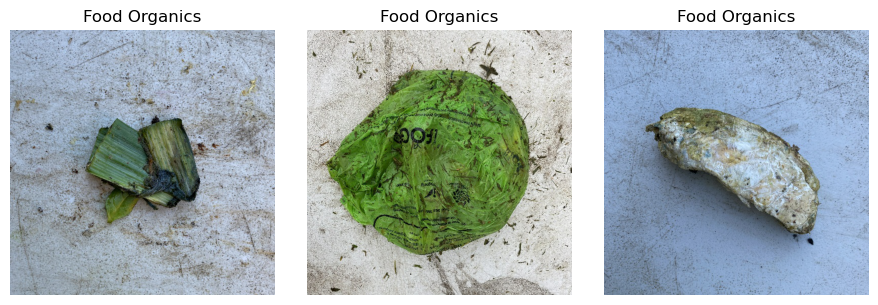

Pickled images for class Food Organics to Pickle_files/images\Food Organics_images.pkl


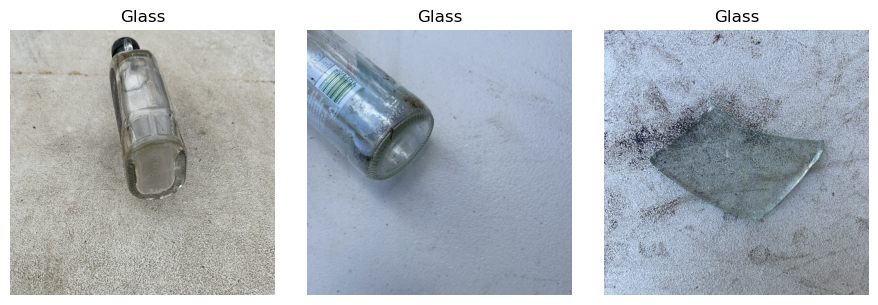

Pickled images for class Glass to Pickle_files/images\Glass_images.pkl


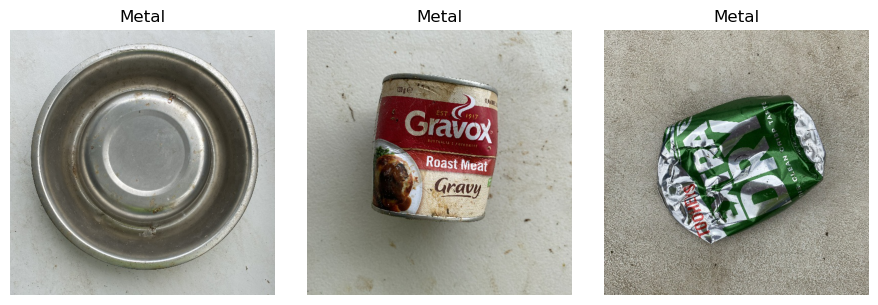

Pickled images for class Metal to Pickle_files/images\Metal_images.pkl


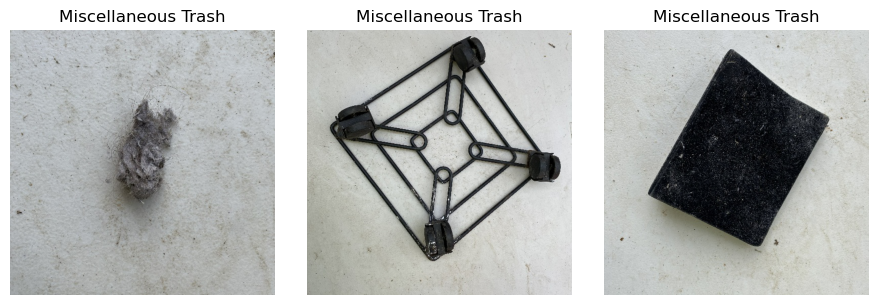

Pickled images for class Miscellaneous Trash to Pickle_files/images\Miscellaneous Trash_images.pkl


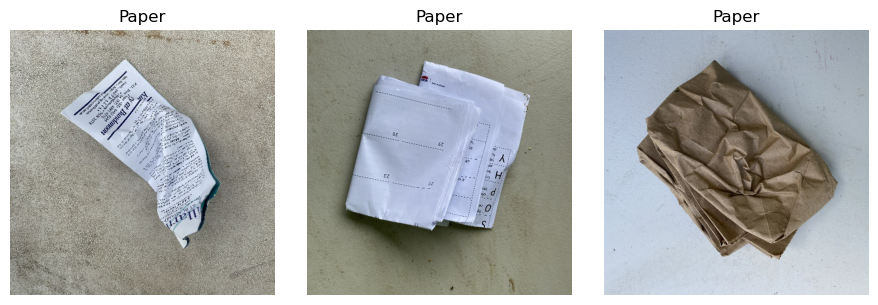

Pickled images for class Paper to Pickle_files/images\Paper_images.pkl


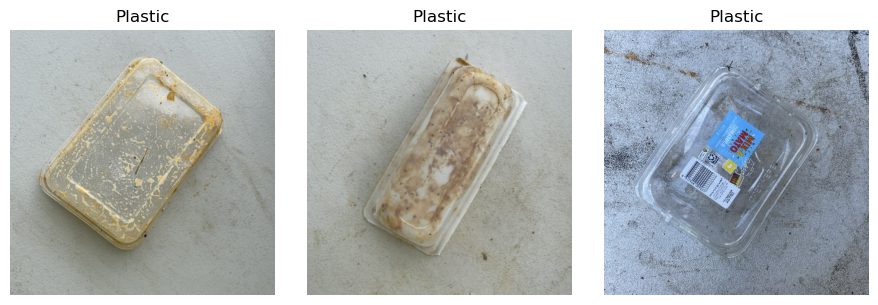

Pickled images for class Plastic to Pickle_files/images\Plastic_images.pkl


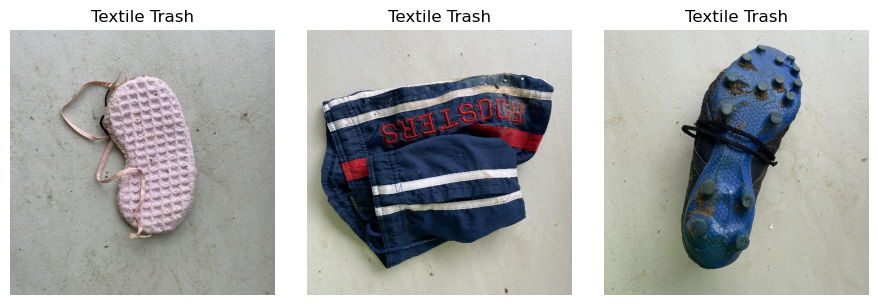

Pickled images for class Textile Trash to Pickle_files/images\Textile Trash_images.pkl


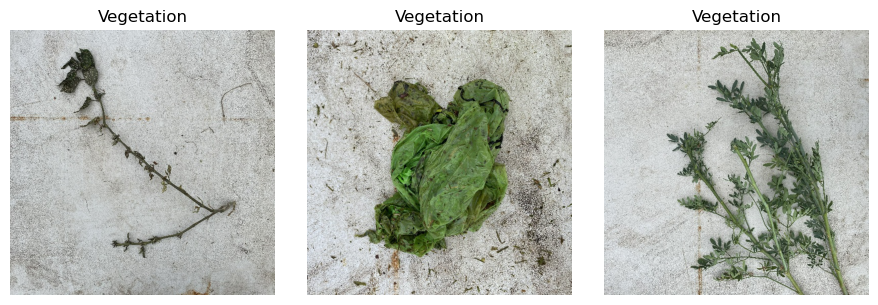

Pickled images for class Vegetation to Pickle_files/images\Vegetation_images.pkl


In [7]:
# plotting random images from each class to understand the images and pickling images for future use
data.visualize_and_pickle(top=3)

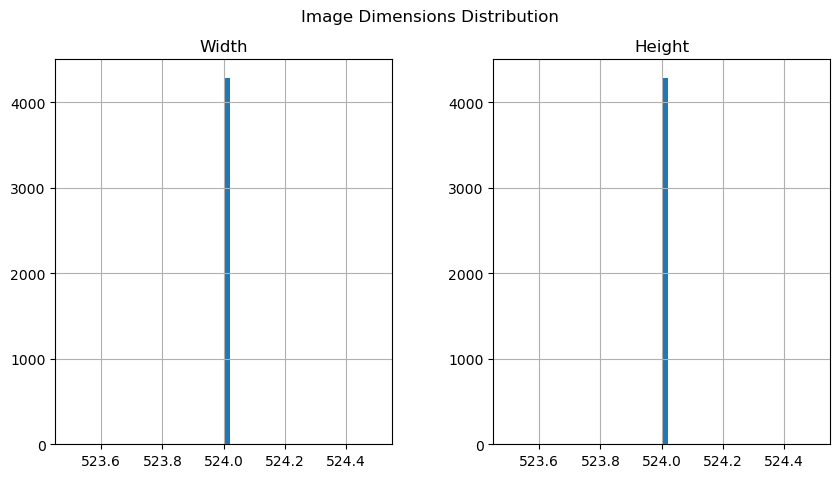

Width  Height
0    524     524
1    524     524
2    524     524
3    524     524
4    524     524

In [8]:
# check the resolution of the images
data.image_dimensions()

In [9]:
# Check for corrupted images 
data.corrupted_images()

 NO CORRUPTED IMAGES FOUND


***
**Observations:**
***
- >The data has 8 classes and  4291 images. the classes are paper, plastic, metals, textiles, food organics, glass, vegetation and miscellaneous trash.

- >The images all have a resolution of 524x524

- >There are no corrupted images present in the data